# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Задание 6

**Правила:**

* Выполненную работу нужно отправить телеграм-боту, адрес которого будет указан на странице курса. 
* Дедлайн **12 декабря в 22:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` 
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлению возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

-----

### Задача 1

Вам необходимо обучить полносвязную нейронную сеть для решения задачи регрессии на двух признаках бостонского датасета. Некоторые параметры уже заданы в ячейках, их менять нельзя.  

- Первым признаком будет признак `boston.data[:, -1]`, который мы ранее использовали на семинаре. Второй признак вам нужно выбрать самостоятельно. Поясните, почему вы выбрали именно его. 

- В качестве функции потерь используйте MSE со стандартными значениями параметров

- Подберите гиперпараметры и конфигурацию сети так, чтобы функция потерь на валидационной выборке принимала значение не выше 29. 

- Ваш код должен быть полностью воспроизводим. То есть для параметров, генерируемых случайным образом, используйте соотвествующие методы фиксации.    

- В процессе обучения выводите графики зависимости таргета от переменной для истинных и модельных данных. 

- Выведите график кривой обучения для обеих выборок. И опишите свои наблюдения и выводы.

- Пишите пояснения к каждой ячейке (что и как Вы выполняете). Ячейки не должны быть переполнены 

- Посчитайте количество параметров Вашей модели. 

### Задача 2

Выберите гиперпараметр, наибольшим образом, на Ваш взгляд, влияющий на скорость и качество обучения нейронной сети. Объясните, почему выбрали его. Проведите эксперимент по сравнению времени обучения сети в зависимости от значения этого параметра, используя модуль `time`. (необходимо хотя бы 4 точки)

Постройте график и таблицу этого сравнения, а в отдельной ячейке напишите выводы. 

### Задача 3

1. Что такое переобучение модели нейронной сети?

2. Когда оно может произойти и почему? 

3. Всегда ли можно столкнуться с переобучением и почему? 

4. Как Вы считаете, возможно ли в задаче 1 переобучить сеть? Почему? 

### Код по умолчанию

In [1]:
# Не менять!
from collections import defaultdict
from collections import OrderedDict
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(palette='Set2', font_scale=1.2)

from IPython.display import clear_output
from sklearn.datasets import load_boston

In [2]:
# Не менять!
boston = load_boston()
boston['data'];
boston['target'];

#### Сформируем тренировочную и валидационную выборки

In [5]:
# Не менять!
# Перемешаем индексы для отделения далее обучающей выборки от валидационной
np.random.seed(1)
indeces = np.arange(len(boston.target))
np.random.shuffle(indeces)

In [6]:
# Не менять!
train_ind = indeces[:int(len(indeces) * 0.8)]
test_ind = indeces[int(len(indeces) * 0.8):]

### Код студента

####  Выбор признака

Воспользуемся L1-регулиризацией для отбора

Отнормируем данные:

In [130]:
from sklearn.preprocessing import StandardScaler
scaled_data_train = StandardScaler().fit_transform(boston.data[train_ind])

scaled_data_test = StandardScaler().fit_transform(boston.data[test_ind])

In [131]:
from sklearn.linear_model import Lasso

Lasso().fit(scaled_data_train, boston.target[train_ind]).coef_

array([-0.        ,  0.        , -0.        ,  0.13424295, -0.        ,
        2.66387666, -0.        , -0.        , -0.        , -0.        ,
       -1.24283065,  0.3180245 , -3.55273063])

Чем больше вес, тем информативнее признак. Самой информативный признак это последний(LSTAT), за ним идет 6-ой(RM).

Так как я буду использовать линейную регрессию, то я оставлю данными отнормированными

#### Далее сформируйте датасет в pytorch-обертке

In [149]:
class BostonDataset(Dataset):
    def __init__(self, boston_dataset, target, indeces, train: bool):
        self.indeces = indeces
        self.train = train
        
        if train:
            self.data = np.array([boston_dataset[:,-1], boston_dataset[:,5]])
            self.labels = target[indeces]
        else:
            self.data = np.array([boston_dataset[:,-1], boston_dataset[:,5]])
            self.labels = target[indeces]
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.data[:,idx] 
        label = self.labels[idx]
        return sample, label

In [162]:
trainset = BostonDataset(scaled_data_train, boston.target ,train_ind, True)
testset = BostonDataset(scaled_data_test, boston.target, test_ind, False)

#### Создайте и обучите нейросеть

In [165]:
# Размер батча
batch_size = 101

In [556]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size= testset.__len__(),
                                         shuffle=False)

Создание нейросети

In [465]:
torch.manual_seed(5)
# Создаем последовательную нейронную сеть
model = nn.Sequential()

# Добавляем линейный слой с выходным размером 1.
# Размер входа равен произведению размерностей данных.
model.add_module('linear_1', nn.Linear(2, 2))
model.add_module('relu_', nn.ReLU())
model.add_module('linear_3', nn.Linear(2, 1))


criterion = nn.MSELoss()

opt = torch.optim.SGD(model.parameters(), lr=0.01)

Обучение нейронной сети

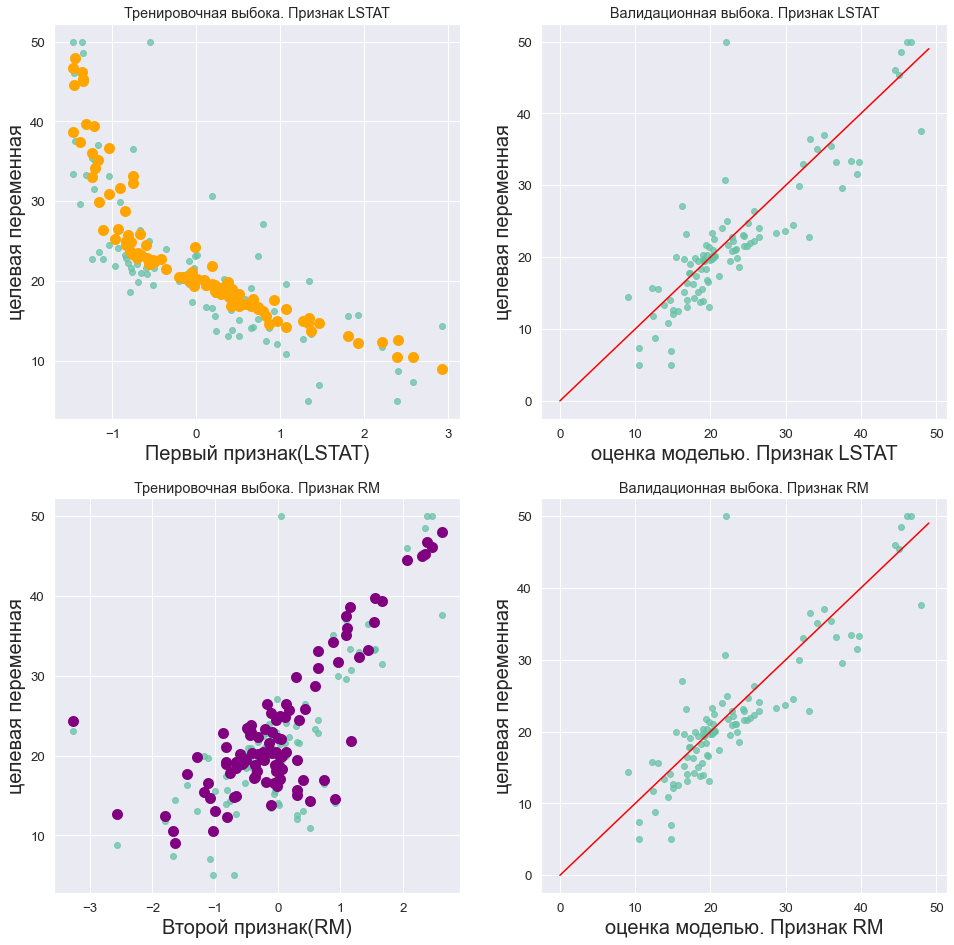

CPU times: user 1min 40s, sys: 1.25 s, total: 1min 42s
Wall time: 1min 31s


22.45304298400879

In [467]:
%%time

num_epochs = 200  # общее кол-во полных проходов ("эпох") по обучаемым данным

num_train_batches = (trainset.__len__()) // batch_size
num_val_batches = 1 # так как для валидационного набора батч - вся выборка (мы так задали размер батча) 

history = defaultdict(lambda: defaultdict(list))

for epoch in range(num_epochs):
    #print(f'epoch {epoch}')
    
    train_loss = 0
    val_loss = 0
    
    
    # Устанавливаем режим обучения
    model.train(True)  

    # На каждой "эпохе" делаем полный проход по данным
    for _, data in enumerate(trainloader):
        
        X_batch = data[0].to(device)
        X_batch = X_batch.float()
        #X_batch = torch.unsqueeze(X_batch, 2).float()
        y_batch = torch.unsqueeze(data[1].to(device), 1).float()
        
        # Обучаемся на батче (одна "итерация" обучения нейросети)
        outs = model(X_batch)
        loss = criterion(outs, y_batch)
        
        # Обратный проход, шаг оптимизатора и зануление градиентов
        loss.backward()
        
        # вывод весов при необходимости
#         for param in model.parameters():
#             print(param) 
            
        opt.step()
        opt.zero_grad()
        
        # Используйте методы тензоров:
        # detach -- для отключения подсчета градиентов
        # cpu -- для перехода на cpu
        # numpy -- чтобы получить numpy массив
        train_loss += loss.detach().cpu().numpy()
        y_pred_np = outs.detach().cpu().numpy()
        y_batch_np = y_batch.cpu().numpy()

    # Подсчитываем лоссы и сохраням в "историю"
    train_loss /= num_train_batches
    history['loss']['train'].append(train_loss)
  
    # Устанавливаем режим тестирования
    model.eval()
    
    # Полный проход по валидации
    with torch.no_grad(): # Отключаем подсчет градиентов, то есть detach не нужен
        for _, data_test in enumerate(testloader):
            X_batch = data_test[0].to(device)
            X_batch = X_batch.float()
            y_batch = torch.unsqueeze(data_test[1].to(device).float(), 1)
            
            outs = model(X_batch)
            loss = criterion(outs, y_batch)
            
            val_loss += loss.cpu().numpy().sum()
            y_pred_np = outs.cpu().numpy()
            y_batch_np = y_batch.cpu().numpy()

    # Подсчитываем лоссы и сохраням в "историю"
    val_loss /= num_val_batches
    history['loss']['val'].append(val_loss)

    # График + вывод лосса
    clear_output(True)
    fig, ax = plt.subplots(2, 2, figsize = (16, 16))
   
    ax[0,0].scatter(X_batch[:,0].numpy(), y_batch.cpu().data.numpy(), alpha=0.75)
    ax[0,0].scatter(X_batch[:,0].numpy(), y_pred_np, color='orange', linewidth=5)
    
    ax[0,0].set_xlabel('Первый признак(LSTAT)', fontsize = 20)
    ax[0,0].set_ylabel('целевая переменная', fontsize = 20)
    ax[0,0].set_title('Тренировочная выбока. Признак LSTAT')
    
    ax[0,1].scatter(y_pred_np, y_batch.cpu().data.numpy(),  alpha=0.75)
    ax[0,1].plot(np.arange(y_batch.cpu().max()), np.arange(y_batch.cpu().max()),  color = 'red')

    ax[0,1].set_xlabel('оценка моделью. Признак LSTAT', fontsize = 20)
    ax[0,1].set_ylabel('целевая переменная', fontsize = 20)
    ax[0,1].set_title('Валидационная выбока. Признак LSTAT')
    
    ax[1,0].scatter(X_batch[:,1].numpy(), y_batch.cpu().data.numpy(), alpha=0.75)
    ax[1,0].scatter(X_batch[:,1].numpy(), y_pred_np, color='purple', linewidth=5)
    
    ax[1,0].set_xlabel('Второй признак(RM)', fontsize = 20)
    ax[1,0].set_ylabel('целевая переменная', fontsize = 20)
    ax[1,0].set_title('Тренировочная выбока. Признак RM')
    
    ax[1,1].scatter(y_pred_np, y_batch.cpu().data.numpy(),  alpha=0.75)
    ax[1,1].plot(np.arange(y_batch.cpu().max()), np.arange(y_batch.cpu().max()),  color = 'red')

    ax[1,1].set_xlabel('оценка моделью. Признак RM', fontsize = 20)
    ax[1,1].set_ylabel('целевая переменная', fontsize = 20)
    ax[1,1].set_title('Валидационная выбока. Признак RM')
    
    plt.show()

history['loss']['val'][-1]

Кривые обучения

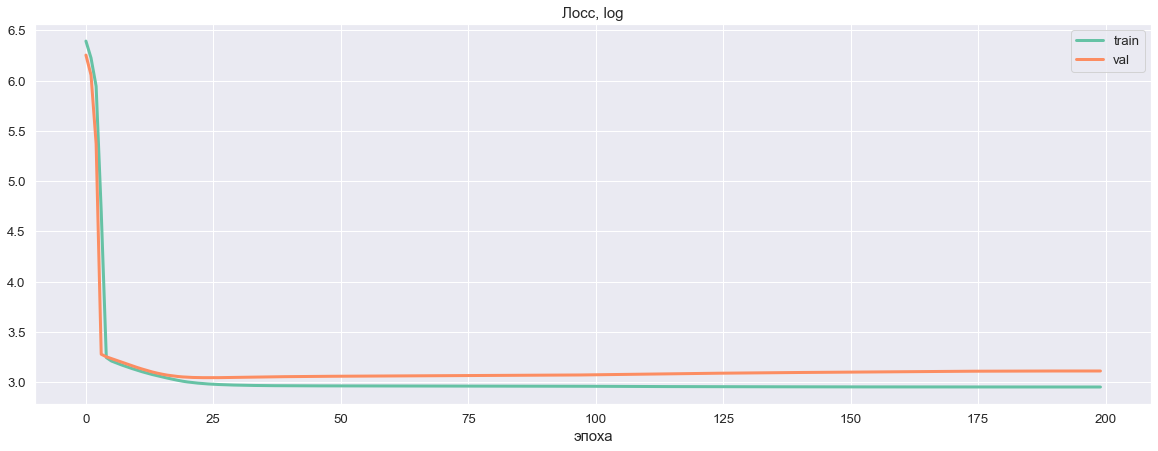

In [468]:
fig = plt.figure(figsize=(20,7))

plt.subplot(1,1,1)
plt.title('Лосс, log', fontsize=15)
plt.plot(np.log(history['loss']['train']), label='train', linewidth = 3)
plt.plot(np.log(history['loss']['val']), label='val', linewidth = 3)
plt.xlabel('эпоха', fontsize=15)
plt.grid(':')

plt.legend()
plt.show()

**Вывод:** Как видим для такой структуры сети 200 эпох -- много, ибо после 20-ой loss на валидационной выборке начинает расти из-за переобучения сети. 
Очень интересно, что такой хороший результат даёт введение лишь одного нелинейного слоя в сеть!

Количество параметров моей модели: 6(первый слой) + 3(третий слой) = 9

Посмотрим на гиперпараметр, который больше всех влияет на время обучения.

У нас 2 очевидный претендента: размер батча и количество эпох

Для начала посмотрим на время обучение с 1 батчем, но при разном количестве эпох.

In [597]:
%%time

batch_size = trainset.__len__()

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

times_epochs = []

for num_epochs in np.arange(50, 5000, 50):
    time_tmp = time.time()
    
    for epoch in range(num_epochs):
        # Создаем последовательную нейронную сеть каждый раз
        model = nn.Sequential()

        model.add_module('linear_1', nn.Linear(2, 2))
        model.add_module('relu_', nn.ReLU())
        model.add_module('linear_3', nn.Linear(2, 1))


        criterion = nn.MSELoss()

        opt = torch.optim.SGD(model.parameters(), lr=0.01)



        train_loss = 0
        val_loss = 0
        model.train(True)  

        # На каждой "эпохе" делаем полный проход по данным
        for _, data in enumerate(trainloader):

            X_batch = data[0].to(device)
            X_batch = X_batch.float()
            y_batch = torch.unsqueeze(data[1].to(device), 1).float()

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            outs = model(X_batch)
            loss = criterion(outs, y_batch)

            # Обратный проход, шаг оптимизатора и зануление градиентов
            loss.backward()

            opt.step()
            opt.zero_grad()

            train_loss += loss.detach().numpy()
            y_pred_np = outs.detach().numpy()
            y_batch_np = y_batch.numpy()
    
    times_epochs.append(time.time() - time_tmp)

CPU times: user 30min 16s, sys: 410 ms, total: 30min 16s
Wall time: 7min 46s


Теперь проделаем тоже самое, но меняя количество бачей(размер батч выборки). Зафиксируем количество эпох на значении 1000

In [593]:
%%time

num_epochs = 1000
batch_size = trainset.__len__()



times_batches = []

for batch_size in range(1, trainset.__len__(), 3):
    trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)
    time_tmp = time.time()
    
    for epoch in range(num_epochs):
        # Создаем последовательную нейронную сеть каждый раз
        model = nn.Sequential()

        model.add_module('linear_1', nn.Linear(2, 2))
        model.add_module('relu_', nn.ReLU())
        model.add_module('linear_3', nn.Linear(2, 1))


        criterion = nn.MSELoss()

        opt = torch.optim.SGD(model.parameters(), lr=0.01)



        train_loss = 0
        val_loss = 0
        model.train(True)  

        # На каждой "эпохе" делаем полный проход по данным
        for _, data in enumerate(trainloader):

            X_batch = data[0].to(device)
            X_batch = X_batch.float()
            y_batch = torch.unsqueeze(data[1].to(device), 1).float()

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            outs = model(X_batch)
            loss = criterion(outs, y_batch)

            # Обратный проход, шаг оптимизатора и зануление градиентов
            loss.backward()

            opt.step()
            opt.zero_grad()

            train_loss += loss.detach().numpy()
            y_pred_np = outs.detach().numpy()
            y_batch_np = y_batch.numpy()
    
    times_batches.append(time.time() - time_tmp)

CPU times: user 19min 25s, sys: 914 ms, total: 19min 25s
Wall time: 8min 47s


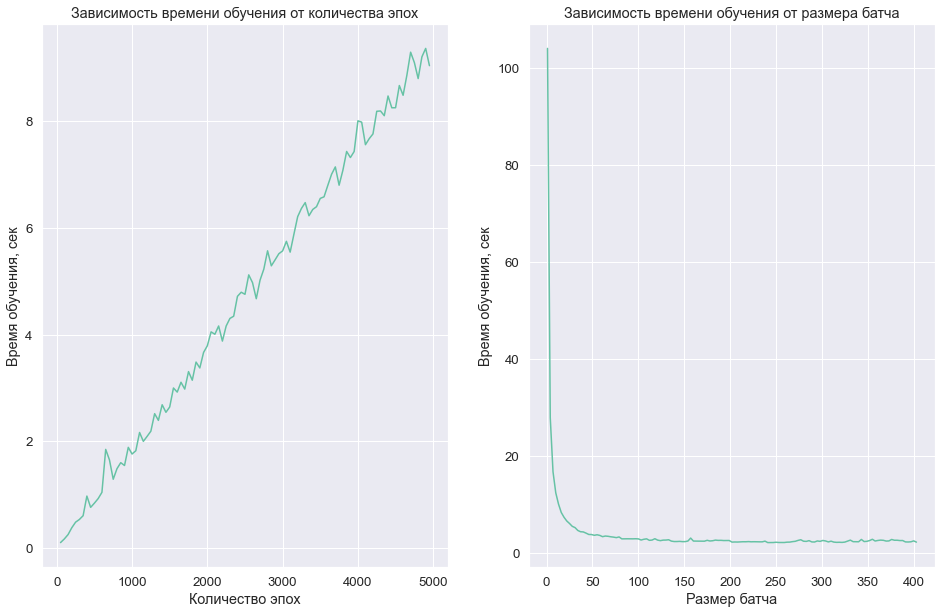

In [599]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
ax[0].plot(np.arange(50, 5000, 50), times_epochs, label='Количество эпох')

ax[0].set_xlabel('Количество эпох')
ax[0].set_ylabel('Время обучения, сек')
ax[0].set_title('Зависимость времени обучения от количества эпох')
    
ax[1].plot(list(range(1, trainset.__len__(), 3)), times_batches, label='Размер батча')

ax[1].set_xlabel('Размер батча')
ax[1].set_ylabel('Время обучения, сек')
ax[1].set_title('Зависимость времени обучения от размера батча')


plt.show()

**Вывод:** Как видим при размере батча больше 1/4 от размера обучающей выборки скорость почти остаётся постоянной(зависящей лишь от количества эпох). Зависимость времени от количества эпох -- линейная, что очевидно с самого начала. При размерах батча меньше 1/4 от размера обучающей выборки зависимость похожа на $1/x^{\alpha}$, где $\alpha >0$.

В итоге при размере батча больше 1/4 от размера выборки время работы зависит от количества эпох линейным образом, при размерах батча меньше 1/4 от размера выборки время работы объясняется правым графиком: оно увеличивается в 2-50 раз по сравнению с предыдущим случаем.

Ну и остались вопросы из 3-ей задачи(перенесу их сюда для удобства):
### Задача 3

1. Что такое переобучение модели нейронной сети?

2. Когда оно может произойти и почему? 

3. Всегда ли можно столкнуться с переобучением и почему? 

4. Как Вы считаете, возможно ли в задаче 1 переобучить сеть? Почему? 

1. Переобучение модели нейронной сети -- это процесс, когда нейронная сеть очень хорошо предсказывает метрики признак на обучающей выборке, но при этом плохо предсказывает значение признака на валидационных данных.
2. Такое может произойти всегда, когда мы обучаемся слишком долго и не используем никакой регуляризации. Это происходит потому, что ассимптотический любая модель стремиться аппроксимировать обучающие данные как можно лучше, и чем больше мы обучаемся, тем больше модель начинает интерполировать именно обучающую выборку подстраиваясь под все её особенности, тем самым теряя обобщающую способность полностью.
3. Не всегда, ибо существует обратная проблема обучения -- недообучение, когда модель не дошла до локального минимума loss-a по параметрам. Но если обучать долго и никак не 'наказывать' модель за переобучение, то оно случится.
4. Да, конечно да! Если взять слишком много параметров в сети и взять размер батча максимальным, то сеть с легкостью переобучится на обчуающей выборке и будет абсолютно не информативной на валидации. Ниже пример :)

In [662]:
# Размер батча
batch_size = 404

In [668]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size= testset.__len__(),
                                         shuffle=False)

Создание нейросети

In [669]:
torch.manual_seed(5)
# Создаем последовательную нейронную сеть
model = nn.Sequential()
model.add_module('norm1',nn.BatchNorm1d(2))
model.add_module('linear_1', nn.Linear(2, 200))
model.add_module('relu_1', nn.ReLU())
model.add_module('norm2',nn.BatchNorm1d(200))
model.add_module('linear_2', nn.Linear(200, 200))
model.add_module('sigm_1', nn.Sigmoid())
model.add_module('norm4',nn.BatchNorm1d(200))
model.add_module('linear_3', nn.Linear(200, 200))
model.add_module('relu_2', nn.ReLU())
model.add_module('norm5',nn.BatchNorm1d(200))
model.add_module('linear_4', nn.Linear(200, 1))
criterion = nn.MSELoss()

opt = torch.optim.SGD(model.parameters(), lr=0.01)

Обучение нейронной сети

In [672]:
%%time

num_epochs = 5000  # общее кол-во полных проходов ("эпох") по обучаемым данным

num_train_batches = (trainset.__len__()) // batch_size
num_val_batches = 1 # так как для валидационного набора батч - вся выборка (мы так задали размер батча) 

history = defaultdict(lambda: defaultdict(list))

for epoch in range(num_epochs):
    #print(f'epoch {epoch}')
    
    train_loss = 0
    val_loss = 0
    
    
    # Устанавливаем режим обучения
    model.train(True)  

    # На каждой "эпохе" делаем полный проход по данным
    for _, data in enumerate(trainloader):
        
        X_batch = data[0].to(device)
        X_batch = X_batch.float()
        #X_batch = torch.unsqueeze(X_batch, 2).float()
        y_batch = torch.unsqueeze(data[1].to(device), 1).float()
        
        # Обучаемся на батче (одна "итерация" обучения нейросети)
        outs = model(X_batch)
        loss = criterion(outs, y_batch)
        
        # Обратный проход, шаг оптимизатора и зануление градиентов
        loss.backward()
        
        # вывод весов при необходимости
#         for param in model.parameters():
#             print(param) 
            
        opt.step()
        opt.zero_grad()
        
        # Используйте методы тензоров:
        # detach -- для отключения подсчета градиентов
        # cpu -- для перехода на cpu
        # numpy -- чтобы получить numpy массив
        train_loss += loss.detach().cpu().numpy()
        y_pred_np = outs.detach().cpu().numpy()
        y_batch_np = y_batch.cpu().numpy()

    # Подсчитываем лоссы и сохраням в "историю"
    train_loss /= num_train_batches
    history['loss']['train'].append(train_loss)
  
    # Устанавливаем режим тестирования
    model.eval()
    
    # Полный проход по валидации
    with torch.no_grad(): # Отключаем подсчет градиентов, то есть detach не нужен
        for _, data_test in enumerate(testloader):
            X_batch = data_test[0].to(device)
            X_batch = X_batch.float()
            y_batch = torch.unsqueeze(data_test[1].to(device).float(), 1)
            
            outs = model(X_batch)
            loss = criterion(outs, y_batch)
            
            val_loss += loss.cpu().numpy().sum()
            y_pred_np = outs.cpu().numpy()
            y_batch_np = y_batch.cpu().numpy()

    # Подсчитываем лоссы и сохраням в "историю"
    val_loss /= num_val_batches
    history['loss']['val'].append(val_loss)

history['loss']['val'][-1]

CPU times: user 1min 30s, sys: 164 ms, total: 1min 30s
Wall time: 23 s


26.636987686157227

Кривые обучения

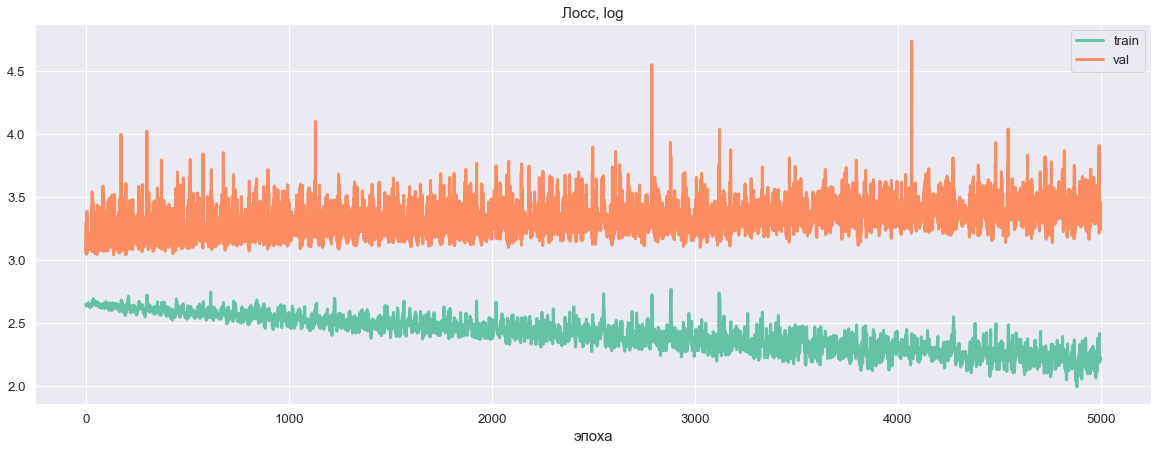

In [673]:
fig = plt.figure(figsize=(20,7))

plt.subplot(1,1,1)
plt.title('Лосс, log', fontsize=15)
plt.plot(np.log(history['loss']['train']), label='train', linewidth = 3)
plt.plot(np.log(history['loss']['val']), label='val', linewidth = 3)
plt.xlabel('эпоха', fontsize=15)
plt.grid(':')

plt.legend()
plt.show()

Как видно loss на трейне убывает, а на валидации -- растет.